In [1]:
import sys,os
sys.path.append('.')
sys.path.append('/home/lev/slot_attention')
from typing import Optional

import pytorch_lightning.loggers as pl_loggers
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
from torchvision import transforms


from slot_attention.train import get_dataset
from slot_attention.data import CLEVRDataModule, ESC50DataModule, SyntaticDataModule, MusanDataModule
from slot_attention.method import SlotAttentionMethod
from slot_attention.model import SlotAttentionModel
from slot_attention.params import SlotAttentionParams
from slot_attention.utils import ImageLogCallback
from slot_attention.utils import rescale, normalize_audio

import hydra 
from omegaconf import DictConfig, OmegaConf

import logging
import torch

from hydra import compose, initialize
from omegaconf import OmegaConf
import hydra 

from omegaconf import DictConfig, OmegaConf

import logging
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [2]:
def main(cfg: DictConfig):
    
    print((OmegaConf.to_yaml(cfg)))

    assert cfg.model.num_slots > 1, "Must have at least 2 slots."

    if cfg.additional.is_verbose:
        print(f"INFO: limiting the dataset to only images with `num_slots - 1` ({cfg.model.num_slots - 1}) objects.")
        if cfg.dataset.num_train_images:
            print(f"INFO: restricting the train dataset size to `num_train_images`: {cfg.dataset.num_train_images}")
        if cfg.dataset.num_val_images:
            print(f"INFO: restricting the validation dataset size to `num_val_images`: {cfg.dataset.num_val_images}")

 
    
    clevr_datamodule = get_dataset(cfg)

    print(f"Training set size (images must have {cfg.model.num_slots - 1} objects):", len(clevr_datamodule.train_dataset))

    model = SlotAttentionModel(
        cfg=cfg
    )

    method = SlotAttentionMethod(model=model, datamodule=clevr_datamodule, hparams=cfg)

    return method, clevr_datamodule
    
    

In [3]:

checkpoint_path = "/home/lev/slot_attention/outputs/2021-12-17/17-43-39/slot_attention_musan/r94zj82u/checkpoints/epoch=219-step=103179.ckpt"


with initialize(config_path="../audio/configs", job_name="test_app"):
    cfg = compose(config_name="/default", overrides=[])
method, datamodule = main(cfg)




data = torch.load(checkpoint_path)
method.load_state_dict(data['state_dict'])


additional:
  logger_project_name: slot_attention_musan
  logger_name: 500epochRun
  is_verbose: true
  debug: false
trainer:
  gpus: 1
  num_sanity_val_steps: 1
  is_logger_enabled: true
  log_every_n_steps: 1
  check_val_every_n_epoch: 5
  accelerator: None
dataset:
  batch_size: 64
  train_batch_size: 64
  val_batch_size: 64
  data_root: None
  num_train_images: -1
  num_val_images: -1
  num_workers: 4
  in_channels: 1
  seed: 1
  name: musan
model:
  slot_size: 64
  resolution:
  - 128
  - 128
  decoder_resolution: null
  num_slots: 5
  num_iterations: 3
  empty_cache: true
  n_samples: 5
  hidden_dims:
  - 64
  - 64
  - 64
  - 64
  kernel_size: 5
  mlp_hidden_size: 128
  opt:
    lr: 0.0004
    warmup_steps_pct: 0.02
    decay_steps_pct: 0.1
    weight_decay: 0.0
    max_epochs: 500
    scheduler_gamma: 0.5

INFO: limiting the dataset to only images with `num_slots - 1` (4) objects.
INFO: restricting the train dataset size to `num_train_images`: -1
INFO: restricting the validation

Global seed set to 0


<All keys matched successfully>

In [4]:
dataset = datamodule.val_dataloader()
idx = 1
method.to(torch.device('cuda'))
method.eval()
for i, batch in enumerate(dataset):
    batch = batch.to(torch.device('cuda'))
    recon_combined, recons, masks, slots = method(batch)
    break


In [12]:
import numpy as np
np.savez(file="try.npy", batch = batch.detach().cpu().numpy(),recon_combined = recon_combined.detach().cpu().numpy())

In [12]:
import librosa
import numpy as np
sample_rate = 22050
n_mels = 128
hop_length = 220
n_fft = 1024
fmin = 64
fmax = 8000


In [6]:
n = np.load("/home/lev/buffer/audio/try.npy.npz")
batch = n['batch']
recon_combined = n['recon_combined']

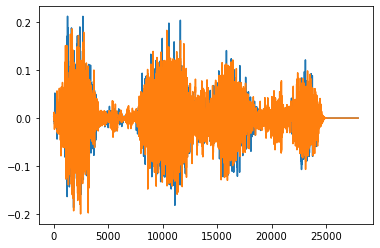

In [28]:
import matplotlib.pyplot as plt
import IPython.display as ipd
original = librosa.feature.inverse.mel_to_audio(batch[0,0], hop_length = hop_length, n_fft=n_fft)
sound = librosa.feature.inverse.mel_to_audio(recon_combined[0,0], hop_length = hop_length, n_fft=n_fft)
plt.plot(sound)
plt.plot(original)
plt.show()
ipd.display(ipd.Audio(sound, rate=sample_rate))



In [27]:
from vscode_audio import Audio
Audio(audio, sr)

ModuleNotFoundError: No module named 'vscode_audio'

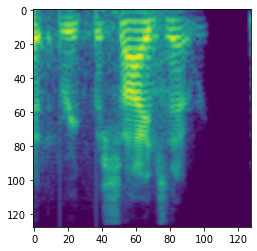

In [27]:
batch
plt.imshow(batch[0,0].cpu().numpy())

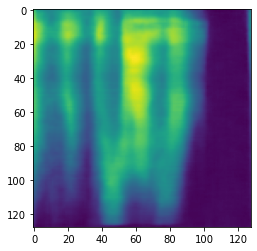

In [24]:
import matplotlib.pyplot as plt
plt.imshow(recon_combined[0,0].cpu().detach().numpy())

In [92]:
import torchaudio
sample_rate = 22050
n_mels = 128
hop_length = 220
n_fft = 1024
fmin = 64
fmax = 8000


inv_melscale = torchaudio.transforms.InverseMelScale(n_stft=n_fft,sample_rate=sample_rate, n_mels=n_mels)


In [ ]:
#new_mel = inv_melscale(recon_combined[0,0].cpu().detach())
inv_mels = inv_melscale(recon_combined[:2,0].cpu().detach())

inv_spect = torchaudio.transforms.InverseSpectrogram(n_fft=int(n_fft / 2 + 1),win_length = 1024, hop_length = 220)
audio = inv_spect(inv_mels.to(torch.cdouble))

In [81]:
# plt.imshow(new_mel.detach().cpu().numpy())

In [83]:
from torchaudio import transforms
batch, freq, time = 2, 257, 100
length = 25344
spectrogram = torch.randn(batch, freq, time, dtype=torch.cdouble)
transform = transforms.InverseSpectrogram(n_fft=512)
waveform = transform(spectrogram)

In [84]:
spectrogram

tensor([[[-1.2789+5.6337e-01j,  0.0429-6.2242e-01j, -0.1808+1.4795e+00j,
           ...,  0.5107+9.1279e-02j, -0.9884-2.2007e-02j,
           0.2447-6.8581e-01j],
         [-0.3054-6.1224e-02j,  0.6534-3.5805e-01j, -1.6770+1.3986e+00j,
           ..., -0.3427-3.2292e-01j, -0.3445-2.6157e-01j,
           0.2183+1.9959e-03j],
         [-1.2418+1.8594e-01j, -1.0166-1.2324e-01j,  0.4576+2.1005e+00j,
           ..., -0.5459+1.0026e-01j,  0.1862+3.5675e-01j,
          -1.2201-1.7985e-01j],
         ...,
         [ 0.1044+8.7088e-01j, -0.4257-3.0239e-01j,  0.4396+1.0882e+00j,
           ..., -0.7261-1.2140e+00j, -1.1071+4.2279e-02j,
           0.1327+4.1721e-01j],
         [ 0.3360-1.0431e+00j, -0.3090+4.8118e-01j,  0.6205-1.0727e+00j,
           ..., -0.0618-4.2112e-01j, -0.2981-4.6506e-01j,
           1.3153+6.1048e-01j],
         [-0.7705-1.1188e+00j,  0.0099-1.0079e+00j,  0.3482-1.1070e+00j,
           ...,  0.7888-1.0746e-01j,  1.3737+1.3590e-01j,
          -1.7338-4.6157e-01j]],

      

In [44]:
new_mel.detach().cpu().numpy().shape

(1024, 128)

In [9]:
import librosa

ImportError: libffi.so.6: cannot open shared object file: No such file or directory